# Introduction

In this notebook, I'm going to asses performance of sequential and OpenMP matrix norm calculation. 

Objectives of the experiment:

* Observe the dependence between the execution time and matrix size
* Observe the dependence between the execution time and number of threads
* Compare the pthreaded version with sequential implementation

In [1]:
%matplotlib inline
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
from mpl_toolkits import mplot3d

# Test settings

For this experiment, I will need the dataset to include 3 types of data:

* Static matrix size, changing number of threads
* Static number of threads, changing matrix size
* Number of threads equal to 1, changing matrix size

Since the only limitation is the number of threads in the computer's CPU, I'm going to generate test inputs based on max number of threads in my CPU(8). Then, for every matrix size, I'll start changing number of threads to ensure I covered all the combinations. 

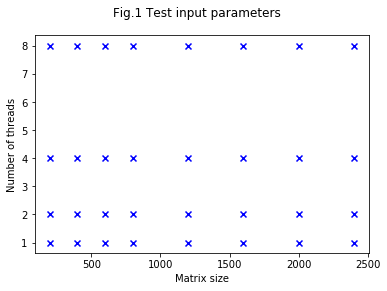

In [2]:
sample_lists = []
cpu_threads_options = [1,2,4,8]
matrix_size_options = [200,400,600,800,1200,1600,2000,2400]

for size in matrix_size_options:
    for threads in cpu_threads_options:
        sample_lists.append((size, int(threads)))
        
sample_input = np.asarray(sample_lists, dtype=np.int)

plt.scatter(sample_input[:,0], sample_input[:,1],c='b',marker='x')
plt.xlabel('Matrix size')
plt.ylabel('Number of threads')
plt.suptitle('Fig.1 Test input parameters')
plt.show()

# Running the experiment

To test the binaries, I'm going to generat bash scripts:

In [4]:
with open('.build/test.bash', 'w') as file:
    file.write("#!/bin/bash\n")
    for matrix_size, threads in sample_lists:
        file.write("./matrix_norm_omp" + " " + str(matrix_size) + " " + str(threads) + "\n")

For test purposes, I'm going to use linux machine with debian-unstable, hardware info:

* CPU Model: Intel(R) Xeon(R) CPU E5-2680 v2 @ 2.80GHz 8 cores
* Memory: 32GB RAM, Swap disabled

I'm going to run generated with saving data to CSV:

```
.build$ bash test.bash |tee -a results.csv
```

And then import them back to this notebook:

In [5]:
sample_output = np.loadtxt(".build/results.csv", delimiter=";")

# Analysing data

## Matrix size to execution time

For this example, I'm going to go with visualizing raw data for every number of threads:

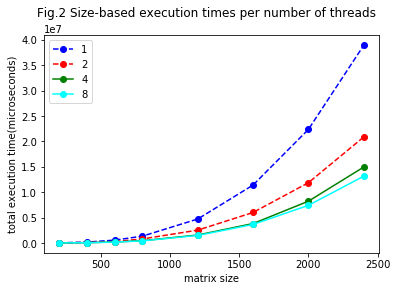

In [6]:
# Table: Matrix Size|Number of threads|Microseconds spent
output_table = np.copy(sample_output)
threads_1 = output_table[np.where(output_table[:,1] == 1)]
threads_2 = output_table[np.where(output_table[:,1] == 2)]
threads_4 = output_table[np.where(output_table[:,1] == 4)]
threads_8 = output_table[np.where(output_table[:,1] == 8)]

plt.plot(threads_1[:,0],threads_1[:,2], color="blue", 
         linestyle='dashed', marker='o', label='1')
plt.plot(threads_2[:,0],threads_2[:,2], color="red", 
         linestyle='dashed', marker='o', label='2')
plt.plot(threads_4[:,0],threads_4[:,2], 
         color="green", marker='o', label='4')
plt.plot(threads_8[:,0],threads_8[:,2], 
         color="cyan", marker='o', label='8')
plt.xlabel('matrix size')
plt.ylabel('total execution time(microseconds)')
plt.suptitle('Fig.2 Size-based execution times per number of threads')
plt.legend()
plt.show()

However, to make this output comparable, the first thing I'm going to do is to scale data according to the matrix sizes by dividing the time spent into matrix multiplication by roughly estimated complexity of the operation, which is matrix size taken to power 3:

$$ t_{adj} = \frac{t_{abs}}{m^3} $$

In [7]:
# Table: Matrix Size|Number of threads|Microseconds spent per cell
output_table_adj = np.copy(sample_output)
output_table_adj[:,2] = output_table_adj[:,2]/np.power(output_table_adj[:,0],3)

Having adjusted the times, let's build the matrix size to execution dependency again:

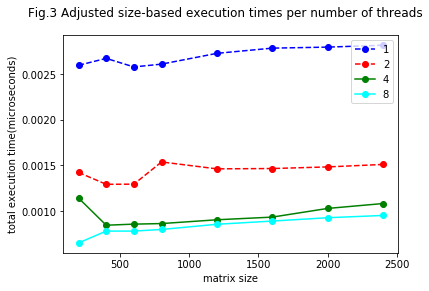

In [8]:
# Table: Matrix Size|Number of threads|Microseconds spent per cell
threads_1_adj = output_table_adj[np.where(output_table_adj[:,1] == 1)]
threads_2_adj = output_table_adj[np.where(output_table_adj[:,1] == 2)]
threads_4_adj = output_table_adj[np.where(output_table_adj[:,1] == 4)]
threads_8_adj = output_table_adj[np.where(output_table_adj[:,1] == 8)]

plt.plot(threads_1_adj[:,0],threads_1_adj[:,2], color="blue", 
         linestyle='dashed', marker='o', label='1')
plt.plot(threads_2_adj[:,0],threads_2_adj[:,2], color="red", 
         linestyle='dashed', marker='o', label='2')
plt.plot(threads_4_adj[:,0],threads_4_adj[:,2], 
         color="green", marker='o', label='4')
plt.plot(threads_8_adj[:,0],threads_8_adj[:,2], 
         color="cyan", marker='o', label='8')
plt.xlabel('matrix size')
plt.ylabel('total execution time(microseconds)')
plt.suptitle('Fig.3 Adjusted size-based execution times per number of threads')
plt.legend()
plt.show()

## Number of threads to execution time


To show how number of threads influences relative execution time, I'd like to leave out the matrix size from the euation, therefore, I'm going to find adjusted min-max times from the matrix sizes and visualize them:

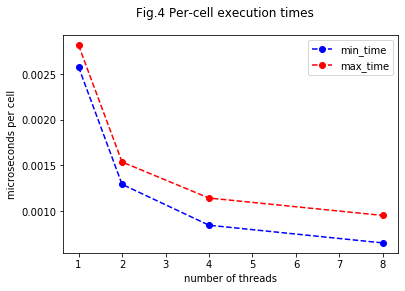

In [9]:
# | 0.Number of threads | 1.min_time | 2.max_time |
def calculate_minmax(blocked_times):
    mx_sizes = np.unique(blocked_times[:,1])
    agg = dict.fromkeys(mx_sizes, np.empty([0,2],dtype=np.float64))
    for i in blocked_times:
        agg[i[1]] = np.append(agg[i[1]], [[i[0], i[2]]], axis=0)

    min_max = np.zeros((mx_sizes.size, 3),dtype=np.float64)
    min_max[:,0] = mx_sizes
    for row in min_max:
        row_table = agg[row[0]]
        min_idx = np.argmin(row_table[:,1])
        max_idx = np.argmax(row_table[:,1])
        row[1] = row_table[min_idx,1]
        row[2] = row_table[max_idx,1]
    return min_max

minmax_per_threads = calculate_minmax(output_table_adj)

plt.plot(minmax_per_threads[:,0],minmax_per_threads[:,1], color="blue", 
         linestyle='dashed', marker='o', label='min_time')
plt.plot(minmax_per_threads[:,0],minmax_per_threads[:,2], color="red", 
         linestyle='dashed', marker='o', label='max_time')
plt.xlabel('number of threads')
plt.ylabel('microseconds per cell')
plt.suptitle('Fig.4 Per-cell execution times')
plt.legend()
plt.show()

## Comparing with pthread

As this implementation is very simillar to the one with pthread, I'd like to compare the resutlts produced by both implementations.

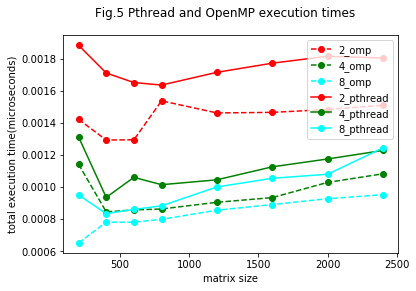

In [19]:
sample_output_pthread = np.loadtxt(".build/results_pthread.csv", delimiter=";")
output_table_pthread_adj = np.copy(sample_output_pthread)
output_table_pthread_adj[:,2] = output_table_pthread_adj[:,2]/np.power(output_table_pthread_adj[:,0],3)
threads_2_pthread = output_table_pthread_adj[np.where(output_table_pthread_adj[:,1] == 2)]
threads_4_pthread = output_table_pthread_adj[np.where(output_table_pthread_adj[:,1] == 4)]
threads_8_pthread = output_table_pthread_adj[np.where(output_table_pthread_adj[:,1] == 8)]


plt.plot(threads_2_adj[:,0],threads_2_adj[:,2], color="red", 
         linestyle='dashed', marker='o', label='2_omp')
plt.plot(threads_4_adj[:,0],threads_4_adj[:,2], 
         linestyle='dashed', color="green", marker='o', label='4_omp')
plt.plot(threads_8_adj[:,0],threads_8_adj[:,2], 
         linestyle='dashed', color="cyan", marker='o', label='8_omp')

plt.plot(threads_2_pthread[:,0],threads_2_pthread[:,2], 
         color="red", marker='o', label='2_pthread')
plt.plot(threads_4_pthread[:,0],threads_4_pthread[:,2], 
         color="green", marker='o', label='4_pthread')
plt.plot(threads_8_pthread[:,0],threads_8_pthread[:,2], 
         color="cyan", marker='o', label='8_pthread')

plt.xlabel('matrix size')
plt.ylabel('total execution time(microseconds)')
plt.suptitle('Fig.5 Pthread and OpenMP execution times')
plt.legend()
plt.show()

# Conclusions

As with pthread:

* Matrix size has very little impact on the time-per-cell calculation and is equvivalent to algorithm complexity $O(n^3)$.
* Effect is improving from increasing number of threads due to calculations going on in parallel.
* There is a significant improvement in comparison with single-threaded version.

When comparing performance of the OpenMP-based implementation with pthread, we can see that OpenMP version(fig 5.) is faster. This can be explained with OpenMP implementing lock-free model with "reduction" pragma, which(unlike pthread) copies over the segment of memory, allowing every thread to run independently, without waiting on acquiring write lock.